In [98]:
import numpy as np
import pandas as pd
import warnings 
import matplotlib.pyplot as plt

from joal import *
from tools import *

from tqdm import tqdm

from moabb.datasets import BNCI2014008, BNCI2015003, bi2013a, bi2014a, bi2014b, bi2015a
from moabb.paradigms import P300

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.transfer import TLSplitter, TLCenter, TLStretch, TLRotate, TLClassifier
from pyriemann.transfer import encode_domains
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.tangentspace import transport
from pyriemann.utils.tangentspace import tangent_space

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.exceptions import ConvergenceWarning

class MyP300(P300):
    def scoring(self, estimator, X, y):
        y_pred = estimator.predict(X)
        return balanced_accuracy_score(y, y_pred)
paradigm = MyP300()

#defining get_subject_data that will extract datasets from moabb databases and put them in the right format
def get_subject_data(subject, X, y, metadata):
    
    # Select datas for a specific subject
    X_subject = X[metadata["subject"] == subject]
    y_subject = y[metadata["subject"] == subject]

    return X_subject, y_subject

In [112]:
# Load the database
dataset = bi2014a()
paradigm = MyP300()
X_raw, y_raw, metadata = paradigm.get_data(dataset)

In [132]:
# split_ratios = [0.5]
split_size = [96]
n_subjects = 0
n_splits = 5
# cv = StratifiedShuffleSplit(n_splits=n_splits, train_size = split_ratios[0], random_state = 42)
cv = StratifiedShuffleSplit(n_splits=n_splits, train_size = split_size[0], random_state = 42)
subject_list = np.unique(metadata["subject"])

In [133]:
n_subjects = subject_list.shape[0] if n_subjects == 0 else n_subjects

train_vecs = [[[] for p in range(n_splits)] for s in range(len(subject_list[0:n_subjects]))]
test_vecs = [[[] for p in range(n_splits)] for s in range(len(subject_list[0:n_subjects]))]
train_labels = [[[] for p in range(n_splits)] for s in range(len(subject_list[0:n_subjects]))]
test_labels = [[[] for p in range(n_splits)] for s in range(len(subject_list[0:n_subjects]))]


In [134]:

for s, subject in enumerate(subject_list[0:n_subjects]):
    # Get subject raw EEG data and label information
    X, y = get_subject_data(subject, X_raw, y_raw, metadata)
    
    # Splitting into train/test
    for nsp, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Train/test EEG data and label information
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create prototype of Target class using ONLY the train data
        # Transform test data using the same prototype
        prt_estimator = ERPCovariances(classes=["Target"], estimator='lwf')
        covs_train = prt_estimator.fit_transform(X_train, y_train)
        covs_test = prt_estimator.transform(X_test)

        # Recentering around Identity matrix
        I = np.eye(covs_train[0].shape[0])
        covs_train = transport(covs_train, I, metric="riemann")
        covs_test = transport(covs_test, I, metric="riemann")

        # Tangent space mapping
        train_tsvecs = tangent_space(covs_train, I, metric="riemann")
        test_tsvecs = tangent_space(covs_test, I, metric="riemann")

        train_vecs[s][nsp] = train_tsvecs.T
        test_vecs[s][nsp] = test_tsvecs.T

        train_labels[s][nsp] = y_train
        test_labels[s][nsp] = y_test

    print("Completed..... %" + str(100*(s+1)/n_subjects))





Completed..... %1.5625
Completed..... %3.125
Completed..... %4.6875
Completed..... %6.25
Completed..... %7.8125
Completed..... %9.375
Completed..... %10.9375
Completed..... %12.5
Completed..... %14.0625
Completed..... %15.625
Completed..... %17.1875
Completed..... %18.75
Completed..... %20.3125
Completed..... %21.875
Completed..... %23.4375
Completed..... %25.0
Completed..... %26.5625
Completed..... %28.125
Completed..... %29.6875
Completed..... %31.25
Completed..... %32.8125
Completed..... %34.375
Completed..... %35.9375
Completed..... %37.5
Completed..... %39.0625
Completed..... %40.625
Completed..... %42.1875
Completed..... %43.75
Completed..... %45.3125
Completed..... %46.875
Completed..... %48.4375
Completed..... %50.0
Completed..... %51.5625
Completed..... %53.125
Completed..... %54.6875
Completed..... %56.25
Completed..... %57.8125
Completed..... %59.375
Completed..... %60.9375
Completed..... %62.5
Completed..... %64.0625
Completed..... %65.625
Completed..... %67.1875
Completed.

In [135]:
clf_base = LinearSVC(tol=1e-6, class_weight="balanced")
acc = [[] for s in range(len(subject_list[0:n_splits]))]
for sub in range(n_subjects):
    for sp in range(n_splits):
        clf_base.fit(train_vecs[sub][sp].T, train_labels[sub][sp])
        y_pred = clf_base.predict(test_vecs[sub][sp].T)
        acc[sp].append(balanced_accuracy_score(test_labels[sub][sp], y_pred))

c:\Users\altindif\Anaconda3\envs\GL_visual\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\altindif\Anaconda3\envs\GL_visual\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\altindif\Anaconda3\envs\GL_visual\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\altindif\Anaconda3\envs\GL_visual\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\altindif\Anaconda3\envs\GL_visual\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\altindif\Anaconda3\envs\GL_visual\lib\sit

In [136]:
# Group Learning Parameters
n_of_boots = 150            # number of bootstraps from each class
bootsize = 25               # number of features used for each bootstrapped feature vector
vecMean = True      		# zero mean of each row of bootstraps
vecNorm = True			    # column normalization of bootstraps
whitening = "svd"		    # 4 types of whitening is avaliable >>> :svd, :pca, :smart, :none
white_dim = 16			    # Whitening dimension >>> typicall 4 is enough
sub_dim = 16
sort_U = True
smart_subspace = 16		    # Subspace dimension for smart whitening >>> typically 32 is enough
normalize_U = "white"	    # columns normalization of U matrices
initialize_U = "smart"    	# initialize the joal algorithm if preferred
random_state = 1

In [137]:
gl_acc = [[] for s in range(len(subject_list[0:n_splits]))]
M = len(train_vecs)
boldB = [[] for s in range(n_splits)]
vsize = train_vecs[0][0].shape[1]

for sp in range(n_splits):
    boots = [[] for m in range(M)]
    for m in range(M):
        boots[m] = create_bootstrap(train_vecs[m][sp], train_labels[m][sp],
            bootsize=bootsize, n_of_boots=n_of_boots, w="u", random_state=random_state)
        if vecMean:
            boots[m] = zero_mean_vecs(boots[m])
            train_vecs[m][sp] = zero_mean_vecs(train_vecs[m][sp])
            test_vecs[m][sp] = zero_mean_vecs(test_vecs[m][sp])
        if vecNorm:
            boots[m] = norm_vecs(boots[m])
            train_vecs[m][sp] = norm_vecs(train_vecs[m][sp])
            test_vecs[m][sp] = norm_vecs(test_vecs[m][sp])          
    
    boldT, boldS, boldW = whiten_data(boots, wh_type=whitening, white_dim=white_dim, smart_subspace=smart_subspace)

    U_init = joal_initializer(boldT, wh_type=whitening)
    boldU = joint_alignment(boldT, U_init=U_init, verbose=True, maxiter=2500)

    boldU_ = norm_U(boldU, norm_type=normalize_U, boldT=boldT)
    boldU_ = flip_and_permute(boldU_, boldT, M, 1, "d", dims=2)

    B = estimate_B(boldU_, boldW, wh_type=whitening, white_dim=white_dim, boldS=boldS)
    boldB[sp] = B
         
    

Pre-whitening started...
Completed..... %0.0
Completed..... %1.5625
Completed..... %3.125
Completed..... %4.6875
Completed..... %6.25
Completed..... %7.8125
Completed..... %9.375
Completed..... %10.9375
Completed..... %12.5
Completed..... %14.0625
Completed..... %15.625
Completed..... %17.1875
Completed..... %18.75
Completed..... %20.3125
Completed..... %21.875
Completed..... %23.4375
Completed..... %25.0
Completed..... %26.5625
Completed..... %28.125
Completed..... %29.6875
Completed..... %31.25
Completed..... %32.8125
Completed..... %34.375
Completed..... %35.9375
Completed..... %37.5
Completed..... %39.0625
Completed..... %40.625
Completed..... %42.1875
Completed..... %43.75
Completed..... %45.3125
Completed..... %46.875
Completed..... %48.4375
Completed..... %50.0
Completed..... %51.5625
Completed..... %53.125
Completed..... %54.6875
Completed..... %56.25
Completed..... %57.8125
Completed..... %59.375
Completed..... %60.9375
Completed..... %62.5
Completed..... %64.0625
Completed...

In [138]:
# tr = [train_vecs[m][0] for m in range(M)]
# te = [test_vecs[m][0] for m in range(M)]
# tr, te = align_features(tr, te, B)
# clf_base = LinearSVC(tol=1e-6, class_weight="balanced")
# clf_base.fit(tr, train_labels[sub][sp])
# y_pred = clf_base.predict(te)
# acc[sp].append(balanced_accuracy_score(test_labels[sub][sp], y_pred))
gl_acc = [[] for s in range(len(subject_list[0:n_splits]))]

for sp in range(n_splits):
    tr = [train_vecs[m][sp] for m in range(M)]
    te = [test_vecs[m][sp] for m in range(M)]
    tr, te = align_features(deepcopy(tr), deepcopy(te), boldB[sp])

    tr_labels = np.concatenate([train_labels[m][sp] for m in range(M)])
    clf_base = LinearSVC(tol=1e-6, class_weight="balanced")
    clf_base.fit(np.concatenate(tr, axis=1).T, tr_labels)

    for m in range(M):
        te_labels = test_labels[m][sp]
        y_pred = clf_base.predict(te[m].T)
        gl_acc[sp].append(balanced_accuracy_score(test_labels[m][sp], y_pred))
    

In [139]:
sw = np.array(acc).mean(axis=0)
gl = np.array(gl_acc).mean(axis=0)
sortkey = np.argsort(sw)[::-1]

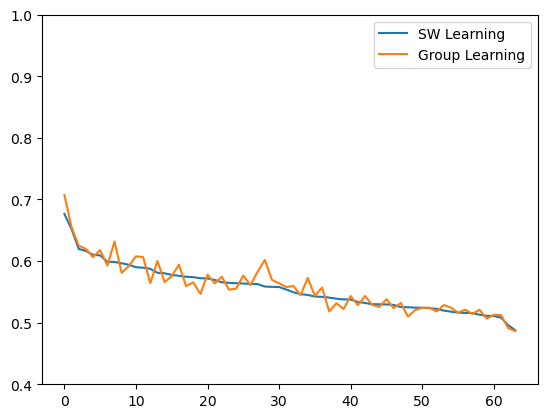

In [140]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(sw[sortkey], label = "SW Learning")
plt.plot(gl[sortkey], label = "Group Learning")
plt.ylim((0.4,1.0))

plt.legend()
plt.show()

In [141]:
np.mean(gl-sw)

0.0023307692028362295